# 汇聚层
:label:`sec_pooling`

<mark style='background-color:#ccccff'>通常当我们处理图像时，我们希望逐渐降低隐藏表示的空间分辨率、聚集信息，这样随着我们在神经网络中层叠的上升，每个神经元对其敏感的感受野（输入）就越大。</mark>

而我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含一只猫呢？”），所以我们最后一层的神经元应该对整个输入的全局敏感。通过逐渐聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层。

此外，当检测较底层的特征时（例如 :numref:`sec_conv_layer`中所讨论的边缘），我们通常希望这些特征保持某种程度上的平移不变性。例如，如果我们拍摄黑白之间轮廓清晰的图像`X`，并将整个图像向右移动一个像素，即`Z[i, j] = X[i, j + 1]`，则新图像`Z`的输出可能大不相同。而在现实中，随着拍摄角度的移动，任何物体几乎不可能发生在同一像素上。即使用三脚架拍摄一个静止的物体，由于快门的移动而引起的相机振动，可能会使所有物体左右移动一个像素（除了高端相机配备了特殊功能来解决这个问题）。

本节将介绍*汇聚*（pooling）层，它具有双重目的：<mark style='background-color:#ccccff'>降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。</mark>

## 最大汇聚层和平均汇聚层

与卷积层类似，汇聚层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为*汇聚窗口*）遍历的每个位置计算一个输出。
然而，不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。
相反，池运算是确定性的，我们通常计算汇聚窗口中所有元素的最大值或平均值。这些操作分别称为*最大汇聚层*（maximum pooling）和*平均汇聚层*（average pooling）。

在这两种情况下，与互相关运算符一样，汇聚窗口从输入张量的左上角开始，从左往右、从上往下的在输入张量内滑动。在汇聚窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值。计算最大值或平均值是取决于使用了最大汇聚层还是平均汇聚层。

![汇聚窗口形状为 $2\times 2$ 的最大汇聚层。着色部分是第一个输出元素，以及用于计算这个输出的输入元素: $\max(0, 1, 3, 4)=4$.](../img/pooling.svg)
:label:`fig_pooling`

 :numref:`fig_pooling`中的输出张量的高度为$2$，宽度为$2$。这四个元素为每个汇聚窗口中的最大值：

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

汇聚窗口形状为$p \times q$的汇聚层称为$p \times q$汇聚层，汇聚操作称为$p \times q$汇聚。

回到本节开头提到的对象边缘检测示例，现在我们将使用卷积层的输出作为$2\times 2$最大汇聚的输入。
设置卷积层输入为`X`，汇聚层输出为`Y`。
无论`X[i, j]`和`X[i, j + 1]`的值相同与否，或`X[i, j + 1]`和`X[i, j + 2]`的值相同与否，汇聚层始终输出`Y[i, j] = 1`。
也就是说，使用$2\times 2$最大汇聚层，即使在高度或宽度上移动一个元素，卷积层仍然可以识别到模式。

在下面的代码中的`pool2d`函数，我们(**实现汇聚层的前向传播**)。
这类似于 :numref:`sec_conv_layer`中的`corr2d`函数。
然而，这里我们没有卷积核，输出为输入中每个区域的最大值或平均值。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def pool2d(X, pool_size, mode='max'):    
    p_h, p_w = pool_size     #窗口大小
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

我们可以构建 :numref:`fig_pooling`中的输入张量`X`，[**验证二维最大汇聚层的输出**]。


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

此外，我们还可以(**验证平均汇聚层**)。


In [4]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## [**填充和步幅**]

与卷积层一样，汇聚层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。
下面，我们用深度学习框架中内置的二维最大汇聚层，来演示汇聚层中填充和步幅的使用。
我们首先构造了一个输入张量`X`，它有四个维度，其中样本数和通道数都是1。




随后，reshape((1, 1, 4, 4)) 方法被用来将这个一维张量重塑为一个四维张量。这里的四个维度分别为：

- 第一个维度大小为1，表示这个张量中只有一个元素（在更高维度的意义上）。
- 第二个维度大小也为1，通常用于表示通道数量，在图像处理中特别有用。
- 第三个和第四个维度大小都为4，表示这个张量在这两个维度上的大小，因此它的形状是一个4x4的矩阵。

In [5]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [4]:
y = torch.arange(9, dtype=torch.float32).reshape((1, 1, 3, 3))
y

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])

默认情况下，(**深度学习框架中的步幅与汇聚窗口的大小相同**)。
因此，如果我们使用形状为`(3, 3)`的汇聚窗口，那么默认情况下，我们得到的步幅形状为`(3, 3)`。


In [6]:
pool2d = nn.MaxPool2d(3)    #3x3的窗口
pool2d(X)

tensor([[[[10.]]]])

[**填充和步幅可以手动设定**]。


In [7]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)     #窗口大小为3，填充为1，步长为2
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

当然，我们可以(**设定一个任意大小的矩形汇聚窗口，并分别设定填充和步幅的高度和宽度**)。


In [8]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 多个通道

在处理多通道输入数据时，[**汇聚层在每个输入通道上单独运算**]，而不是像卷积层一样在通道上对输入进行汇总。
这意味着汇聚层的输出通道数与输入通道数相同。
下面，我们将在通道维度上连结张量`X`和`X + 1`，以构建具有2个通道的输入。


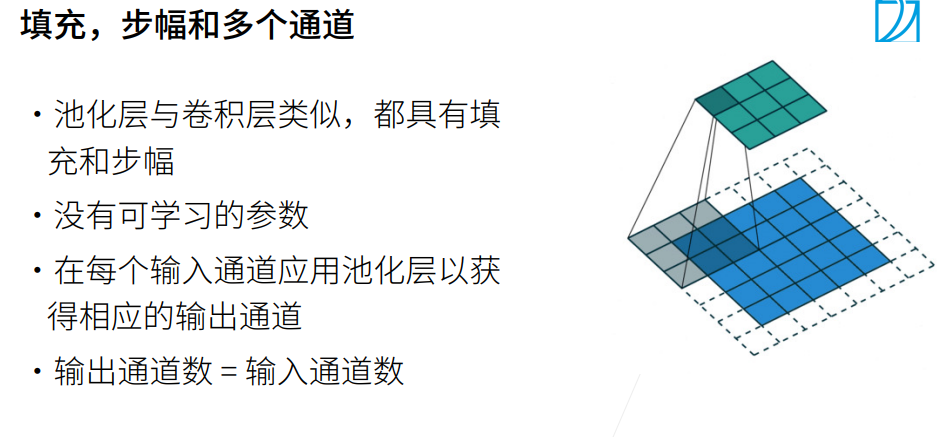

池化层在每个输入通道上单独运算

In [9]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

如下所示，汇聚后输出通道的数量仍然是2。


In [10]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 小结

* 对于给定输入元素，最大汇聚层会输出该窗口内的最大值，平均汇聚层会输出该窗口内的平均值。
* 汇聚层的主要优点之一是减轻卷积层对位置的过度敏感。
* 我们可以指定汇聚层的填充和步幅。
* 使用最大汇聚层以及大于1的步幅，可减少空间维度（如高度和宽度）。
* 汇聚层的输出通道数与输入通道数相同。

## 练习

1. 尝试将平均汇聚层作为卷积层的特殊情况实现。
1. 尝试将最大汇聚层作为卷积层的特殊情况实现。
1. 假设汇聚层的输入大小为$c\times h\times w$，则汇聚窗口的形状为$p_h\times p_w$，填充为$(p_h, p_w)$，步幅为$(s_h, s_w)$。这个汇聚层的计算成本是多少？
1. 为什么最大汇聚层和平均汇聚层的工作方式不同？
1. 我们是否需要最小汇聚层？可以用已知函数替换它吗？
1. 除了平均汇聚层和最大汇聚层，是否有其它函数可以考虑（提示：回想一下`softmax`）？为什么它不流行？


[Discussions](https://discuss.d2l.ai/t/1857)
